## 1. Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import IPython
import itertools
import textwrap
from IPython.display import (display, HTML, display_html)

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor,
                              AdaBoostRegressor, BaggingRegressor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import QuantileTransformer

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from shap import TreeExplainer, summary_plot
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import PolynomialFeatures

from sklearn.compose import TransformedTargetRegressor

C:\Users\angjo\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def preprocess(df):
    
    '''
    Fungsi ini untuk mempermudah preprocessing data
    '''
    
    ### PREPROCESS 'LISTING' ###
    # diekstrak kata pertama untuk mendapatkan 'produsen'
    df['produsen'] = df['listing'].str.split().str.get(0)
    
    # diekstrak kata terakhir untuk mendapatkan 'tahun'
    df['tahun'] = df['listing'].str.split().str.get(-1)
    
    # diremove tanda baca pada 'tahun'
    df['tahun'] = df['tahun'].str.replace('[()<]', '')
    
    # diubah tipe data 'tahun' menjadi integer
    df['tahun'] = df['tahun'].astype('int')
    
    # diambil nama mobil saja dgn cara hapus kata pertama dan terakhir
    df['listing'] = df['listing'].str.split(n=1).str[1]
    df['listing'] = df['listing'].str.split(n=1).str[-2]
    
    
    ### PREPROCESS 'ODO' ###
    # diremove tanda baca dan huruf sehingga hanya tersisa angka
    df['odo'] = df['odo'].str.replace('-', ' ')
    df['odo'] = df['odo'].str.replace('[.>Km]', '')
    
    # displit sehingga diperoleh batas bawah dan batas atas odo
    df['odo_bawah'] = df['odo'].str.split().str.get(0)
    df['odo_atas'] = df['odo'].str.split().str.get(-1)
    
    # diubah tipe data 'odo_bawah' dan 'odo_atas' menjadi integer
    df[['odo_bawah', 'odo_atas']] = df[['odo_bawah', 'odo_atas']].astype('int')
    
    # diambil nilai rata-rata dari batas bawah dan batas atas odo
    df['odo_mean'] = (df['odo_bawah'] + df['odo_atas']) / 2
    
    # mengganti outlier dengan nilai rata-rata
    df['odo_mean'] = df['odo_mean'].replace(999999.0, np.nan)
    df['odo_mean'] = df['odo_mean'].fillna(df['odo_mean'].mean())
    
    
    ### PREPROCESS 'MESIN' ###
    # untuk sementara missing value di-replace dengan 0
    df['mesin'] = df['mesin'].fillna('0')
    
    # dihapus tanda baca dan huruf sehingga hanya tersisa angka
    df['mesin'] = df['mesin'].str.replace(' - ', ' ')
    df['mesin'] = df['mesin'].str.replace('[.><cc]', '')
    
    # displit sehingga diperoleh batas bawah dan batas atas mesin
    df['mesin_bawah'] = df['mesin'].str.split().str.get(0)
    df['mesin_atas'] = df['mesin'].str.split().str.get(-1)
    
    # diubah tipe data 'mesin_atas' dan 'mesin_bawah' menjadi integer
    df[['mesin_bawah', 'mesin_atas']] = df[['mesin_bawah', 'mesin_atas']].astype('int')

    # diambil nilai rata-rata dari batas bawah dan batas atas mesin
    df['mesin_mean'] = (df['mesin_bawah'] + df['mesin_atas']) / 2
    
    # angka 0 dikembalikan menjadi missing value, lalu diganti dengan nilai rata-rata keseluruhan
    df['mesin_mean'] = df['mesin_mean'].replace(0, np.nan)
    df['mesin_mean'] = df['mesin_mean'].fillna(df['mesin_mean'].mean())
    
    
    ### PREPROCESS 'TAHUN' ###
    # 'tahun' diubah menjadi usia
    df['usia'] = 2022 - df['tahun']
    
    
    ## HAPUS BARIS DAN FITUR TIDAK PENTING ###
    df = df.drop([
        'odo', 'odo_bawah', 'odo_atas', 'mesin', 'mesin_bawah', 'mesin_atas', 'tahun'
    ], axis=1)

    return df

In [3]:
def ordinal(train, test):
    
    '''
    Fitur ini untuk mempermudah ordinal encoding
    '''
    
    ### MEMASTIKAN UNIQUE VALUE TRAIN ADA DI DALAM LINGKUP UNIQUE VALUE TEST ###
    dict_penjual = dict(zip(test['penjual'].unique(), test['penjual'].unique()))
    train['penjual'] = train['penjual'].map(dict_penjual)
    
    dict_bahan_bakar = dict(zip(test['bahan_bakar'].unique(), test['bahan_bakar'].unique()))
    train['bahan_bakar'] = train['bahan_bakar'].map(dict_bahan_bakar)

    dict_produsen = dict(zip(test['produsen'].unique(), test['produsen'].unique()))
    train['produsen'] = train['produsen'].map(dict_produsen)

    dict_listing = dict(zip(test['listing'].unique(), test['listing'].unique()))
    train['listing'] = train['listing'].map(dict_listing)

    train = train.dropna()
    
    
    ### DIGABUNG ###
    df = pd.concat([train, test])
    
    
    ### ENCODING ###
    catcol = [i for i in df.select_dtypes(include=['object', 'category']) if i != 'id']
    encoder = OrdinalEncoder()
    df[catcol] = encoder.fit_transform(df[catcol])
    
    
    ### DIPISAH KEMBALI MENJADI TRAIN DAN TEST ##
    train = df[df['harga'].notnull()].reset_index(drop=True)
    test = df[df['harga'].isnull()].reset_index(drop=True)

    return train, test

In [4]:
def onehot(train, test):
    
    '''
    Fitur ini untuk mempermudah one hot encoding
    
    '''
    
    ### MEMASTIKAN UNIQUE VALUE TRAIN ADA DI DALAM LINGKUP UNIQUE VALUE TEST ###
    dict_penjual = dict(zip(test['penjual'].unique(), test['penjual'].unique()))
    train['penjual'] = train['penjual'].map(dict_penjual)
    
    dict_bahan_bakar = dict(zip(test['bahan_bakar'].unique(), test['bahan_bakar'].unique()))
    train['bahan_bakar'] = train['bahan_bakar'].map(dict_bahan_bakar)

    dict_produsen = dict(zip(test['produsen'].unique(), test['produsen'].unique()))
    train['produsen'] = train['produsen'].map(dict_produsen)

    dict_listing = dict(zip(test['listing'].unique(), test['listing'].unique()))
    train['listing'] = train['listing'].map(dict_listing)

    train = train.dropna()
    
    
    ### DIGABUNG ###
    df = pd.concat([train, test])
    
    
    ### ENCODING ###
    catcol = [i for i in df.select_dtypes(include=['object', 'category']) if i != 'id']    
    df = pd.get_dummies(df, columns=catcol, drop_first=True)
    
    
    ### DIPISAH KEMBALI MENJADI TRAIN DAN TEST ##
    train = df[df['harga'].notnull()].reset_index(drop=True)
    test = df[df['harga'].isnull()].reset_index(drop=True)

    return train, test

In [5]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')

pre_train = preprocess(raw_train)
pre_test = preprocess(raw_test)

train, test = ordinal(pre_train, pre_test)

In [6]:
len(train), len(test)

(1732, 397)

In [7]:
pre_train.isnull().sum()

id               0
listing        259
bahan_bakar      7
transmisi        0
penjual          4
harga            0
produsen        47
odo_mean         0
mesin_mean       0
usia             0
dtype: int64

## 2. Feature Importance

In [8]:
def shap(model, X_train, X_valid, y_train):
    fitted = model.fit(X_train, y_train)
    explainer = TreeExplainer(fitted)
    values = explainer.shap_values(X_valid)
    
    summary_plot(values, X_valid)
    
    df = pd.DataFrame(np.abs(values), columns=X_valid.columns).mean()
    df = df.sort_values(ascending=False)
    
    return df.index.tolist()

In [9]:
X = train.drop(['id', 'harga'], axis=1)
y = train['harga']

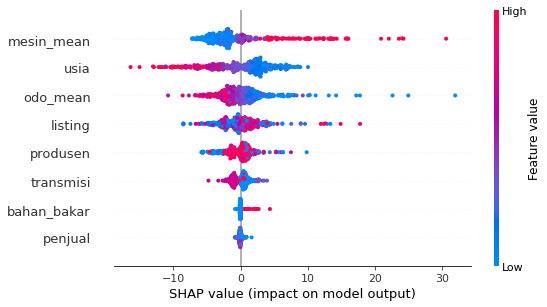

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=408)
model = XGBRegressor()
shapfeats = shap(model, X_train, X_valid, y_train)

## 3. Feature Interaction

In [11]:
def top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (
                        feature_names[i] + "-" + feature_names[j],
                        aggregate_interactions[i][j] * 2,
                    )
                )
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))

    return interaction_features[:k], interaction_values[:k]

In [12]:
def plot_interaction(pairs, values):
    plt.bar(pairs, values)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [13]:
from xgboost import DMatrix

fitted = model.fit(X_train, y_train)
booster = model.get_booster()
interaction = booster.predict(DMatrix(X_train, y_train), pred_interactions=True)

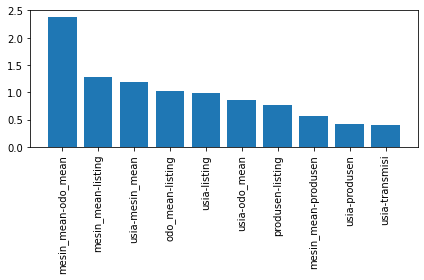

In [14]:
top_inter_feats, top_inter_vals = top_k_interactions(X_train.columns, interaction, 10)
plot_interaction(top_inter_feats, top_inter_vals)

## 4. Modeling dan validasi

In [15]:
def reg_validate(models, X, y, cv, scoring):
    
    '''
    Fungsi ini untuk mempermudah validasi model
    '''
    
    data = []
    
    for name, current_model in models:
        current_data = {}
        error = -cross_val_score(estimator=current_model, X=X, y=y, cv=cv, scoring=scoring)
        
        current_data['model'] = name
        current_data['error'] = '{:.5f}'.format(error.mean())
        
        data.append(current_data)
    
    dframe = pd.DataFrame(data)
    dframe = dframe.sort_values(by='error', ascending=True)
    dframe = dframe.reset_index(drop=True)
        
    return dframe

In [16]:
from sklearn.ensemble import HistGradientBoostingRegressor

models = [
    ['XGB', XGBRegressor()],
    ['CatBoost', CatBoostRegressor(logging_level='Silent')],
    # ['LGBM', LGBMRegressor()],
    # ['TTR', TransformedTargetRegressor()],
    ['ExtraTrees', ExtraTreesRegressor(criterion='absolute_error', random_state=100)],
    #['AdaBoost', AdaBoostRegressor()],
    ['RandomForest', RandomForestRegressor(random_state=100)],
    #['DecisionTree', DecisionTreeRegressor()],
    # ['MLP', MLPRegressor()]
]

cv = KFold(n_splits=5, shuffle=True, random_state=100)

### Ordinal encoding

In [17]:
val_01 = reg_validate(models, X, y, cv, 'neg_mean_absolute_percentage_error')
val_01

,model,error
0,XGB,0.12610
1,CatBoost,0.12913
2,ExtraTrees,0.14402
3,RandomForest,0.15192


### One hot encoding

In [18]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')

pre_train = preprocess(raw_train)
pre_test = preprocess(raw_test)

train, test = onehot(pre_train, pre_test)

In [19]:
train.head()

,id,harga,odo_mean,mesin_mean,usia,listing_318i,listing_320i,listing_488,listing_520i,listing_8,...,produsen_mazda,produsen_mercedes-benz,produsen_mini,produsen_mitsubishi,produsen_nissan,produsen_porsche,produsen_suzuki,produsen_toyota,produsen_volkswagen,produsen_wuling
0,4,22.9,42500.0,1750.0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,5,46.2,67594.0,2393.0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,6,9.5,152500.0,1250.0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,42.9,47500.0,1750.0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,35.9,17500.0,1250.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
X = train.drop(['id', 'harga'], axis=1)
y = train['harga']

In [21]:
val_02 = reg_validate(models, X, y, cv, 'neg_mean_absolute_percentage_error')
val_02

,model,error
0,ExtraTrees,0.09543
1,RandomForest,0.11709
2,XGB,0.12511
3,CatBoost,0.12733


### 4. Hyperparameter Tuning

In [22]:
from hyperopt import (hp, tpe, fmin, rand, 
                      Trials, STATUS_OK)

In [23]:
def reg_hyperopt(model, X, y, cv, scoring, max_evals):    
    
    def extra_trees_obj(params):
        params = {
            'n_estimators': int(params['n_estimators']),
            'min_samples_split': int(params['min_samples_split']),
            # 'min_samples_leaf': int(params['min_samples_leaf']),
            # 'max_depth': int(params['max_depth'])
        }

        estimator = ExtraTreesRegressor(**params, criterion='absolute_error')
        errors = -cross_val_score(estimator=estimator, X=X, y=y, cv=cv, scoring=scoring, n_jobs=-1)
    
        return errors.mean()


    extra_trees_space = {
        'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
        'min_samples_split': hp.quniform('min_samples_split', 2, 32, 2),
        # 'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 64, 2),
        # 'max_depth': hp.quniform('max_depth', 64, 256, 8)
    }

    
    if model == 'extra':
        fn = extra_trees_obj
        space = extra_trees_space
        
    else:
        raise ValueError('Yeet!')
        
    tuned = fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=max_evals)
    
    print('')
    print('tuned_{} = {}'.format(model, tuned))
    print('')

In [24]:
# reg_hyperopt('extra', X, y, cv, 'neg_mean_absolute_percentage_error', 50)

## SUBMISSION

In [25]:
def submission(X, y, model, test):
    fitted = model.fit(X, y)
    sub = pd.DataFrame()
    X_test = test.drop(['id', 'harga'], axis=1)
    
    sub['id'] = test['id']
    sub['harga'] = fitted.predict(X_test)
    sub['harga'] = sub['harga'].round(1)
    
    return sub